In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from numpy.linalg import multi_dot, inv
%matplotlib inline

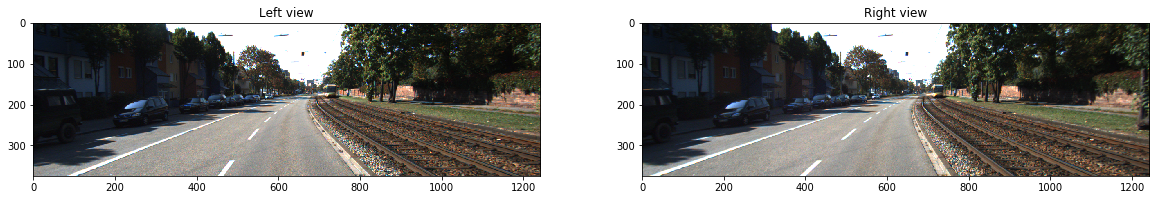

In [2]:
image_idx = 11
image_dir = '/data/KITTI/KITTI_RAW/2011_09_26/2011_09_26_drive_0001_sync/'
left_view = mpimg.imread(image_dir + 'image_02/data/' + "{:010}".format(image_idx) + '.png')
right_view = mpimg.imread(image_dir + 'image_03/data/' + "{:010}".format(image_idx) + '.png')
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.set_title('Left view')
ax1.imshow(left_view)
ax2.set_title('Right view')
ax2.imshow(right_view)
plt.show()

### Warping Function

$p_{3} = K_{3}R_{3}K_{2}^{-1}Z_{w}p_{2}-K_{3}R_{3}C_{3}$ <br>
http://www.epixea.com/research/multi-view-coding-thesisch4.html <br>
Annotations: <br>

- 2: Original scene (left), 3: Warped / synthesized scene (target right)
- $p_{2}$: Source pixel position on original scene ($\mathbb{R}^{2}$)
- $p_{3}$: Warped pixel position on synthesized scene ($\mathbb{R}^{2}$)
- $Z_{w}$: Depth of point in real scene (Point $P_{w} = (X_{w}, Y_{w}, Z_{w})^{T} \in \mathbb{R}^{3}$)
- $K_{2}, K_{3}$: Intrinsic parameters ($\mathbb{R}_{3x3}$)
- $R_{3}$: Rotation matrix (related to camera position 1) ($\mathbb{R}_{3x3}$)
- $C_{3}$: Camera center potision (related to camera position 1) ($\mathbb{R}^{3}$)

https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT <br>
The color and grayscale cameras are mounted close to each other (~6 cm), the baseline of both stereo rigs is
approximately 54 cm. <br>
The opening angle of the cameras (left-right) is approximately 90 degrees.

In [3]:
K2 = np.array([[9.597910e+02, 0.000000e+00, 6.960217e+02],
               [0.000000e+00, 9.569251e+02, 2.241806e+02],
               [0.000000e+00, 0.000000e+00, 1.000000e+00]])
K3 = np.array([[9.037596e+02, 0.000000e+00, 6.957519e+02],
               [0.000000e+00, 9.019653e+02, 2.242509e+02],
               [0.000000e+00, 0.000000e+00,1.000000e+00]])

#left to right
R3 = np.eye(3) #No rotation
C3 = np.array([[0.54], [.0], [.0]]) #Baseline length = 54 cm
K3R3_K2 = multi_dot([K3, R3, inv(K2)])
K3R3C3 = multi_dot([K3, R3, C3])

#right to left
R2 = np.eye(3) #No rotation
C2 = np.array([[-0.54], [.0], [.0]]) #Baseline length = 54 cm
K2R2_K3 = multi_dot([K2, R2, inv(K3)])
K2R2C2 = multi_dot([K2, R2, C2])

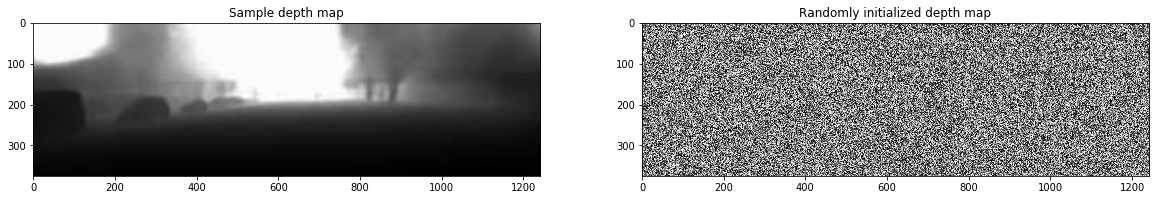

In [20]:
#Sample depth map output from another repo
ref = mpimg.imread('/home/szuyu/workspace/semodepth/encode/2011_09_26_drive_0001/0000000011.jpg', 0)
ref = ref / 3 #reverse previous enhancement
ref = cv2.resize(ref, (left_view.shape[1], left_view.shape[0]))

rd = np.dot(np.random.rand(ref.shape[0], ref.shape[1]), np.amax(ref))
#rd = np.zeros_like(ref)#*np.mean(ref)
#for i in range(ref.shape[0]):
#    for j in range(ref.shape[1]):
#        rd[i][j] = max(np.mean(ref[:][i]) - abs(j - 600)*0.01, 1)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.imshow(ref, cmap='gray')
ax1.set_title("Sample depth map")
ax2.imshow(rd, 'gray')
ax2.set_title("Randomly initialized depth map")
plt.show()

In [5]:
good_depths = []
poor_depths = []
colors = []

#Bind original pixels with depth maps
for x in range(left_view.shape[1]): #width
    for y in range(left_view.shape[0]):
        good_depths.append([x,y,ref[y][x]])
        poor_depths.append([x,y,rd[y][x]])
        colors.append(left_view[y][x])


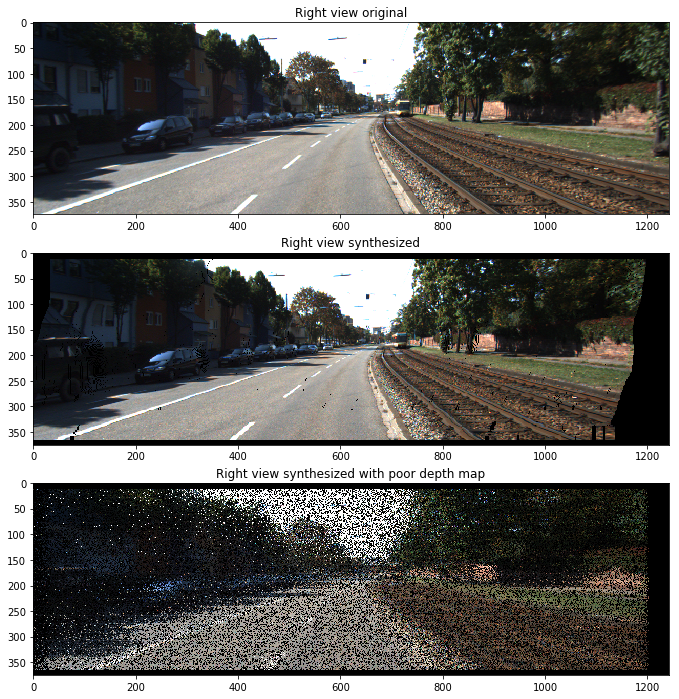

In [6]:
def remap(p2, Zw, direction):
    if direction == 'R2L':
        p3 = np.dot(K2R2_K3, Zw*p2) - K2R2C2
    elif direction == 'L2R':
        p3 = np.dot(K3R3_K2, Zw*p2) - K3R3C3
        
    return [float(p3[0] / p3[2]), float(p3[1] / p3[2])]

def plot_recon(good, bad, src_pts, direction):
    #remap pixel positions to complementary view (2-D)
    px, py = [], []
    for [x,y,z] in good:     
        p3_x, p3_y = remap(np.array([[x],[y],[1]]), z, direction)
        px.append(int(p3_x))
        py.append(int(p3_y))

    #map original color of source image pixels
    src_pts = np.dot(src_pts, 255).astype(int)
    canvas1 = np.zeros_like(left_view,dtype=np.uint8)
    for i in range(len(px)):
        if(0 <= px[i] < left_view.shape[1] and 0 <= py[i] < left_view.shape[0]):
            #c = (int(src_pts[i][0]), int(src_pts[i][1]), int(src_pts[i][2]))
            #cv2.circle(canvas1, (px[i],py[i]), 1, c, -1)
            canvas1[py[i]][px[i]][0] = src_pts[i][0]
            canvas1[py[i]][px[i]][1] = src_pts[i][1]
            canvas1[py[i]][px[i]][2] = src_pts[i][2]

    canvas2 = np.zeros_like(left_view,dtype=np.uint8)
    px, py = [], []
    for [x,y,z] in bad:     
        p3_x, p3_y = remap(np.array([[x],[y],[1]]), z, direction)
        px.append(int(p3_x))
        py.append(int(p3_y))
    
    for i in range(len(px)):
        if(0 <= px[i] < left_view.shape[1] and 0 <= py[i] < left_view.shape[0]):
            canvas2[py[i]][px[i]][0] = src_pts[i][0]
            canvas2[py[i]][px[i]][1] = src_pts[i][1]
            canvas2[py[i]][px[i]][2] = src_pts[i][2]

    f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(25,12))#20,6 FOR 2
    ax1.set_title('Right view original')
    ax1.imshow((right_view*255).astype(np.uint8))
    ax2.set_title('Right view synthesized')
    ax2.imshow(canvas1)
    ax3.set_title('Right view synthesized with poor depth map')
    ax3.imshow(canvas2)
    plt.show()
    
    return canvas1, canvas2

syn_good, syn_poor = plot_recon(good_depths, poor_depths, colors, direction='L2R')

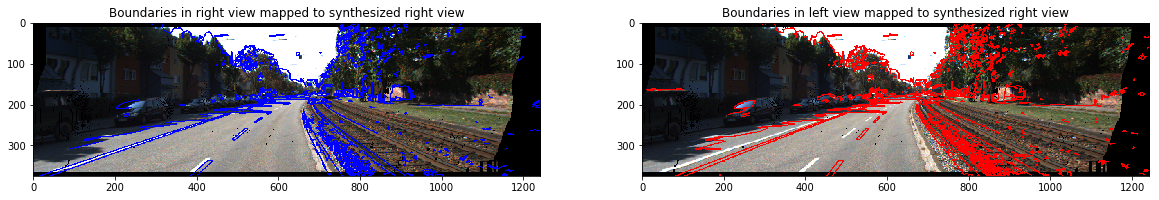

In [7]:
#demonstrate mapping
gray = cv2.cvtColor((left_view*255).astype(np.uint8),cv2.COLOR_BGR2GRAY)
left_edges = cv2.Canny(gray,150,400,apertureSize = 3)
gray = cv2.cvtColor((right_view*255).astype(np.uint8),cv2.COLOR_BGR2GRAY)
right_edges = cv2.Canny(gray,150,400,apertureSize = 3)

canvas1 = syn_good.copy()
for x in range(left_view.shape[1]):
    for y in range(left_view.shape[0]):
        if left_edges[y][x] == 255:
            cv2.circle(canvas1, (x, y), 1, (255,0,0), -1)
            
canvas2 = syn_good.copy()
for x in range(right_view.shape[1]):
    for y in range(right_view.shape[0]):
        if right_edges[y][x] == 255:
            cv2.circle(canvas2, (x, y), 1, (0,0,255), -1)
            
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax2.set_title("Boundaries in left view mapped to synthesized right view")
ax2.imshow(canvas1)
ax1.set_title("Boundaries in right view mapped to synthesized right view")
ax1.imshow(canvas2)

plt.show()

In [8]:
#pixel-wise alignment loss function
def avg_pixel_loss(tar, syn):
    loss = 0
    pt = 0
    tar = (np.dot(tar,255)).astype(int)
    syn = syn.astype(int)
    for y in range(tar.shape[0]):
        for x in range(tar.shape[1]): #~460k points
            if sum(tar[y][x]) > 1:
                pt += 1
                loss += ( (tar[y][x][0]-syn[y][x][0])**2
                         +(tar[y][x][1]-syn[y][x][1])**2
                         +(tar[y][x][2]-syn[y][x][2])**2)
    #print(pt)
    return round(loss/pt, 4)

print(avg_pixel_loss(right_view, syn_good), avg_pixel_loss(right_view, syn_poor))

8386.915 20090.5016
